In [1]:
import numpy as np
import joblib
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from copy import deepcopy
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

domains = ["amides", "sulfonamides", "ROH", "heterocycles", "alkyl amines", "anilines"]
DB_NAME='rxn_db.sql'

In [2]:
full_id = joblib.load('./array_joblibs/full_id_arrays_by_nuc.joblib')
full_desc = joblib.load('./array_joblibs/full_desc_arrays_by_nuc.joblib')
full_yield = joblib.load('./array_joblibs/full_y_arrays_by_nuc.joblib')

## Preparing arrays

In [3]:
def split_by_elec(id_array_dict, 
                  domain_list=domains):
    '''Splits reaction arrays into those that employ...
    1) electrophile 1
    2) electrophile 2 that is part of a small screen & follow-up exps
    3) all other rxns with electrophile 2.
    
    Parameters
    ----------
    id_array_dict : dict
        key : str (domain)
        val : id_array (np.2darray)
    domain_list : list of str
        list of nucleophile domains to consider.
    
    Returns
    -------
    inds_by_nuc : dict
        key : elec scheme (as shown above in 1,2,3)
        val : inds for each domain (list of three lists)
    '''
    inds_by_nuc = {}
    for i,domain in enumerate(domain_list) :
        id_array = id_array_dict[domain]
        list_of_inds = [[],[],[]]
        for i,row in enumerate(id_array):
            if row[1]==1:
                list_of_inds[0].append(i)
            else :
                if (row[2] in [1,2,8] and row[-1]==1) or\
                   (row[2] in [1,2,8] and row[3]==4 and row[-1]==2) or\
                   (row[2]==15 and row[3] in [1,2,3] and row[-1]==2):
                    list_of_inds[1].append(i)
                else : 
                    list_of_inds[2].append(i)
        inds_by_nuc.update({domain:list_of_inds})
    return inds_by_nuc


def prep_arrays(id_array_dict, desc_array_dict, y_array_dict,
                inds_by_nuc, domain_list=domains):
    ''' Divides full arrays into source and target arrays.
    
    Parameters
    ----------
    id_array_dict, desc_array_dict, y_array_dict : dict
        key : str (domain)
        val : id_array / desc_array (np.2darray)
               y_array ( np.1darray)
    inds_by_nuc : dict
        key : str (domain)
        val : list of lists (inds by electrophile scheme)
    domain_list : list of str
        list of nucleophile domains to consider.
    
    Returns
    -------
    source_id_dict, source_desc_dict, source_y_dict,\
    target_id_dict, target_desc_dict, target_y_dict
    '''
    source_id_dict, source_desc_dict, source_y_dict = {}, {}, {}
    target_id_dict, target_desc_dict, target_y_dict = {}, {}, {}
    for i, domain in enumerate(domain_list):
        if i < 3:
            source_inds = inds_by_nuc[domain][0] + inds_by_nuc[domain][1]
            target_inds = inds_by_nuc[domain][2]
        else :
            source_inds = inds_by_nuc[domain][0]
            target_inds = inds_by_nuc[domain][1] + inds_by_nuc[domain][2]
        source_id_dict.update({domain:id_array_dict[domain][source_inds]})
        source_desc_dict.update({domain:desc_array_dict[domain][source_inds]})
        source_y_dict.update({domain:y_array_dict[domain][source_inds]})
        target_id_dict.update({domain:id_array_dict[domain][target_inds]})
        target_desc_dict.update({domain:desc_array_dict[domain][target_inds]})
        target_y_dict.update({domain:y_array_dict[domain][target_inds]})
    return source_id_dict, source_desc_dict, source_y_dict,\
           target_id_dict, target_desc_dict, target_y_dict
        

def plot_neg_portion(y_array_dict, inds_by_nuc, 
                     domain_list=domains, save=True):
    ''' Plots portion of negative reactions in each domain,
    by electrophile scheme.
    
    Parameters
    ----------
    y_array_dict : dict
        key : str (domain)
        val : np.1darray (binary yield labels)
    inds_by_nuc : dict
        key : str (domain)
        val : list of lists (inds for each scheme)
    domain_list : list of str
        domains considered.
    save : bool
        whether to save the resulting plot.
    
    Returns
    -------
    None
    '''
    neg_portion_by_domain = {
            "Domain":[],
            "Portion of Negatives":[],
            "Data":[]
    }
    for domain in domain_list:
        y_array = y_array_dict[domain]
        ind_list = inds_by_nuc[domain]
        elec1_neg_portion = 1-(sum(y_array[ind_list[0]])/len(ind_list[0]))
        common_elec2_neg_portion = 1-(sum(y_array[ind_list[1]])/len(ind_list[1]))
        uncommon_elec2_neg_portion = 1-(sum(y_array[ind_list[2]])/len(ind_list[2]))
        neg_portion_by_domain["Domain"].extend([domain]*3)
        neg_portion_by_domain["Portion of Negatives"].extend(
            [elec1_neg_portion,
             common_elec2_neg_portion,
             uncommon_elec2_neg_portion]
        )
        neg_portion_by_domain["Data"].extend(["Elec1", "Elec2 Train", "Elec2 Test"])
    
    fig, ax = plt.subplots()
    p=sns.barplot(data=neg_portion_by_domain, 
               x="Domain", y="Portion of Negatives", hue="Data",
               palette="viridis")
    ax.legend(bbox_to_anchor=(1.01,0.98))
    ax.set_yticks([x/5 for x in range(6)])
    ax.set_yticklabels([x/5 for x in range(6)])
    ax.set_ylabel("Portion of Negatives", fontsize=14)
    ax.set_xticks(p.get_xticks())
    ax.set_xticklabels(p.get_xticklabels(), rotation=45,
                       horizontalalignment='right')
    ax.set_xlabel("Domain", fontsize=14)
    #ax.set_title("Label Distribution by Electrophile")
    for i in range(len(domain_list)-1):
        ax.axvline(i+0.5, alpha=0.7, linestyle='--', c='gray')
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
    if save:
        plt.savefig("./figures/figureS2.pdf", dpi=300, format='pdf', bbox_inches="tight")

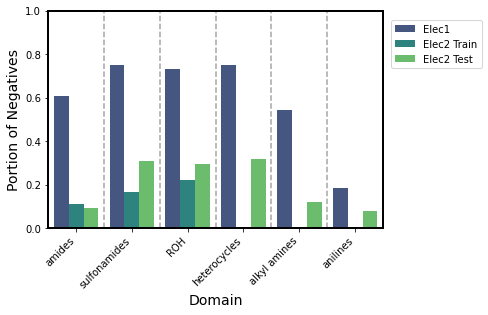

In [4]:
### Figure S3
inds_by_nuc = split_by_elec(full_id)
plot_neg_portion(full_yield, inds_by_nuc, save=False)

In [5]:
if os.path.exists("./array_joblibs/source_id_dict.joblib"):
    source_id_dict = joblib.load("./array_joblibs/source_id_dict.joblib")
    source_desc_dict = joblib.load("./array_joblibs/source_desc_dict.joblib")
    source_y_dict = joblib.load("./array_joblibs/source_y_dict.joblib")
    target_id_dict = joblib.load("./array_joblibs/target_id_dict.joblib")
    target_desc_dict = joblib.load("./array_joblibs/target_desc_dict.joblib")
    target_y_dict = joblib.load("./array_joblibs/target_y_dict.joblib")
else : 
    source_id_dict, source_desc_dict, source_y_dict,\
    target_id_dict, target_desc_dict, target_y_dict = prep_arrays(full_id, full_desc, full_yield,
                inds_by_nuc)
    joblib.dump(source_id_dict, "./array_joblibs/source_id_dict.joblib")
    joblib.dump(source_desc_dict, "./array_joblibs/source_desc_dict.joblib")
    joblib.dump(source_y_dict, "./array_joblibs/source_y_dict.joblib")
    joblib.dump(target_id_dict, "./array_joblibs/target_id_dict.joblib")
    joblib.dump(target_desc_dict, "./array_joblibs/target_desc_dict.joblib")
    joblib.dump(target_y_dict, "./array_joblibs/target_y_dict.joblib")

## Performance by model complexity

In [3]:
def screen_depth_and_num_trees(source_X, source_y,
                               target_X_list, target_y_list,
                               depth_list, num_estimator_list,
                               max_fpr=1, cv_result_dict=None,
                               random_state=42):
    '''Screens the max_depth and n_estimators parameters. 
    
    Parameters
    ----------
    source_X, source_y : np.2d/1darrays
        descriptor and yield arrays of a single source domain.
    target_X_list, target_y_list : list of np.2d/1darrays
        descriptor and yield arrays of target domains.
    depth_list : list of ints & None
        max_depth values to consider.
    num_estimator_list : list of ints
        n_estimators values to consider.
    max_fpr : float [0,1]
        max false positive rate
    cv_result_dict : None or dict
        • None if first model is being considered.
        • dict if evaluating with more models.
    random_state : int
    
    Returns
    -------
    cv_result_dict : dict
        informations on performance on training, CV, target data.
    '''
    if cv_result_dict is None :
        cv_result_dict = {"Depth":[],
                          "Num Trees":[],
                          "Training Score":[],
                          "Training Sd":[],
                          "CV Score":[],
                          "CV Sd":[],
                          "Model":[],
                          "Transfer Score":[]}

    def update_dict(param_value_tuple, gridsearch, model,
                    transfer_score):
        cv_result_dict["Depth"].append(param_value_tuple[0])
        cv_result_dict["Num Trees"].append(param_value_tuple[1])
        cv_result_dict["Training Score"].append(
                    gridsearch.cv_results_["mean_train_score"][0]
        )
        cv_result_dict["Training Sd"].append(
                    gridsearch.cv_results_["std_train_score"][0]
        )
        cv_result_dict["CV Score"].append(
                    gridsearch.cv_results_["mean_test_score"][0]
        )
        cv_result_dict["CV Sd"].append(
                    gridsearch.cv_results_["std_test_score"][0]
        )
        cv_result_dict["Model"].append(model)
        cv_result_dict["Transfer Score"].append(transfer_score)
    
    def get_transfer_roc(gridsearch, target_X_list, target_y_list,
                         max_fpr):
        model = gridsearch.best_estimator_
        transfer_rocs = []
        for target_X, target_y in zip(target_X_list, target_y_list):
            proba = model.predict_proba(target_X)[:,1]
            roc = roc_auc_score(target_y, proba, max_fpr=max_fpr)
            transfer_rocs.append(roc)
        return model, transfer_rocs
    
    for i, depth in enumerate(depth_list):
        for j, num_trees in enumerate(num_estimator_list):
            rfc = RandomForestClassifier(random_state=random_state)
            param_grid = {"max_depth":[depth],
                          "n_estimators":[num_trees]}
            
            if min([sum(source_y), len(source_y)-sum(source_y)])> 5:
                cv = 5
            elif min([sum(source_y), len(source_y)-sum(source_y)])>1:
                cv = int(min([sum(source_y), len(source_y)-sum(source_y)]))
            else :
                print("Not enough class members.")
                break
            
            grid_rfc = GridSearchCV(rfc, 
                                    param_grid=param_grid,
                                    scoring="roc_auc", cv=cv,
                                    return_train_score=True)
            grid_rfc.fit(source_X, source_y)
            model, transfer_rocs = get_transfer_roc(grid_rfc, target_X_list,
                                                    target_y_list, max_fpr)
            update_dict((depth, num_trees), 
                        grid_rfc, model, transfer_rocs)        
    return cv_result_dict


def prep_heatmap_friendly_arrays(cv_result_dict, 
                                 depth_list, num_tree_list,
                                 num_random_states_considered,
                                 num_targets_considered=3):
    '''Prepares an array that can plot a heatmap.
    
    Parameters
    ----------
    cv_result_dict : dict
        output of function above.
    depth_list, num_tree_list : lists of ints
        input of function above.
    num_random_states_considered : int
        number of models initiated differently.
        
    Returns
    -------
    train_score_array, CV_score_array: np.2darrays
        performances on IN-DOMAIN training and CV sets.
    het_score_array, alkyl_score_array, anil_score_array : np.2darrays
        performances of the source models on elec2 datasets in
        heterocycle, alkyl amines, aniline domains, respectively.
    '''
    train_score_array = np.zeros((len(depth_list), len(num_tree_list),
                                  num_random_states_considered))
    CV_score_array = np.zeros_like(train_score_array)
    het_score_array = np.zeros_like(train_score_array)
    alkyl_score_array = np.zeros_like(train_score_array)
    anil_score_array = np.zeros_like(train_score_array)
    
    tree_len = len(num_tree_list)
    depth_len = len(depth_list)
    for l in range(num_random_states_considered):
        for i, depth in enumerate(cv_result_dict["Depth"]):
            num_tree = cv_result_dict["Num Trees"][i]
            j = depth_list.index(depth)
            k = num_tree_list.index(num_tree)
            ind = tree_len*depth_len*l+depth_len*j+k
            train_score_array[j,k,l] = cv_result_dict["Training Score"][ind]
            CV_score_array[j,k,l] = cv_result_dict["CV Score"][ind]
            het_score_array[j,k,l] = cv_result_dict["Transfer Score"][ind][0]
            if num_targets_considered == 3:
                alkyl_score_array[j,k,l] = cv_result_dict["Transfer Score"][ind][1]
                anil_score_array[j,k,l] = cv_result_dict["Transfer Score"][ind][2]
    if num_targets_considered == 3:
        return train_score_array, CV_score_array,\
               het_score_array, alkyl_score_array, anil_score_array
    elif num_targets_considered == 1:
        return train_score_array, CV_score_array,\
               het_score_array

def prep_heatmap(score_array, depth_list, num_tree_list, 
                 fig_num, source, target, std=True):
    ''' Plots heatmaps of performances at different levels.
    
    Parameters
    ----------
    score_array : np.2darray
        output of function above.
    depth_list, num_tree_list : list of ints
        inputs used throughout.
        
    Returns
    -------
    None
    '''
    xlen = len(num_tree_list) -1
    ylen = len(depth_list) - 1
    fig, ax = plt.subplots(figsize=(xlen,ylen))
    avg_score = np.mean(score_array,axis=2)
    annot_labels = [[0]*avg_score.shape[1] for x in range(avg_score.shape[0])]
    if std:
        std_score = np.std(score_array, axis=2)
        for i in range(avg_score.shape[0]):
            for j in range(avg_score.shape[1]):
                if round(std_score[i,j],2) >= 0.01 : 
                    avg_std = f"{round(avg_score[i,j],2)}\n({round(std_score[i,j],2)})"
                else : 
                    avg_std = f"{round(avg_score[i,j],2)}"
                annot_labels[i][j] = avg_std
    else :
        for i in range(avg_score.shape[0]):
            for j in range(avg_score.shape[1]):
                annot_labels[i][j] = round(avg_score[i,j],2)
    sns.heatmap(avg_score, cmap='viridis', cbar=False, square=True,
                vmin=0.5, vmax=1, annot=annot_labels, fmt='')
    ax.set_yticklabels([str(x) for x in depth_list], 
                       verticalalignment="center")
    ax.set_ylabel("Maximum Depth of Trees", fontsize=14)
    ax.set_xticklabels(num_tree_list)
    ax.set_xlabel("Number of Trees", fontsize=14)
    if fig_num is not None:
        fig.savefig(f"./figures/{fig_num}_{source}_{target}.pdf",
                            dpi=300, format="pdf", bbox_inches="tight")

# N-nucs --> other N-nucs

In [25]:
depth_list = [1,2,3,5,None]
num_tree_list = [1,3,5,10,20,50,100,200]
amide_CV_dict_list = []

# Roughly takes 6min
for i in tqdm(range(25)):
    if i==0 : cv_result_dict=None
    else : cv_result_dict = amide_CV_dict_list
    amide_CV_dict_list = screen_depth_and_num_trees(
                        source_desc_dict["amides"], 
                        source_y_dict["amides"],
                        [target_desc_dict[x] for x in ["heterocycles", "alkyl amines", "anilines"]],
                        [target_y_dict[x] for x in ["heterocycles", "alkyl amines", "anilines"]],
                        depth_list, num_tree_list, random_state=42+i,
                        cv_result_dict=cv_result_dict
                    )

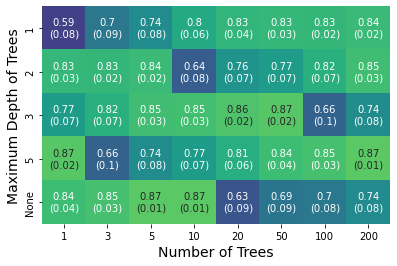

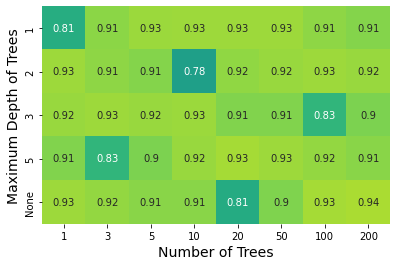

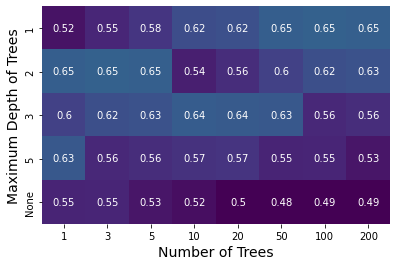

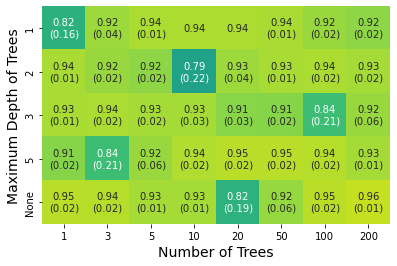

In [38]:
_, amide_CV_score_array,\
amide_het_score_array, amide_alkyl_score_array, amide_anil_score_array = prep_heatmap_friendly_arrays(
                                amide_CV_dict_list, depth_list, num_tree_list, 25
                        )
prep_heatmap(amide_CV_score_array, depth_list, num_tree_list,
             "FigS4", "amides", "CV", True) #Figure S4
prep_heatmap(amide_anil_score_array, depth_list, num_tree_list,
             "Fig4B", "amides", "aniline", False) #Figure 4B
prep_heatmap(amide_het_score_array, depth_list, num_tree_list,
             "Fig4C", "amides", "heterocycle", False) #Figure 4C
prep_heatmap(amide_alkyl_score_array, depth_list, num_tree_list,
             "FigS7", "amides", "alkyl", True) #Figure S7

In [30]:
### Source : sulfonamide
# Roughly takes 8min
for i in tqdm(range(25)):
    if i==0 : cv_result_dict=None
    else : cv_result_dict = sulfonamide_CV_dict_list
    sulfonamide_CV_dict_list = screen_depth_and_num_trees(
                        source_desc_dict["sulfonamides"], 
                        source_y_dict["sulfonamides"],
                        [target_desc_dict[x] for x in ["heterocycles", "alkyl amines", "anilines"]],
                        [target_y_dict[x] for x in ["heterocycles", "alkyl amines", "anilines"]],
                        depth_list, num_tree_list, random_state=42+i,
                        cv_result_dict=cv_result_dict
                    )

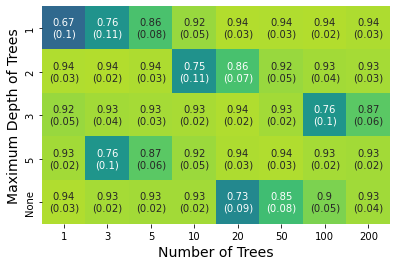

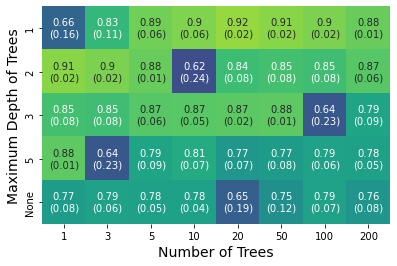

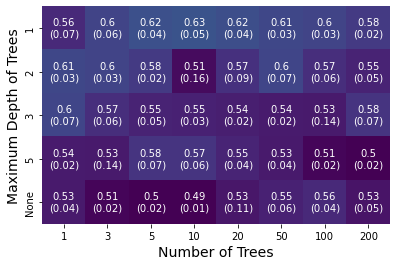

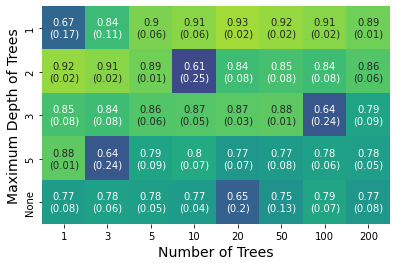

In [37]:
_, sulfon_CV_score_array,\
sulfon_het_score_array, sulfon_alkyl_score_array, sulfon_anil_score_array = prep_heatmap_friendly_arrays(
                                CV_dict_list[1], depth_list, num_tree_list, 25
                        )
prep_heatmap(sulfon_CV_score_array, depth_list, num_tree_list,
             "FigS5", "sulfonamide", "CV", True) #Figure S5
prep_heatmap(sulfon_anil_score_array, depth_list, num_tree_list,
             "FigS8", "sulfonamide", "aniline", True) #Figure S8
prep_heatmap(sulfon_het_score_array, depth_list, num_tree_list,
             "FigS8", "sulfonamide", "heterocycle", True) #Figure S8
prep_heatmap(sulfon_alkyl_score_array, depth_list, num_tree_list,
             "FigS8", "sulfonamide", "alkyl", True) #Figure S8

In [32]:
### Source : ROH
# Roughly takes 7min
for i in tqdm(range(25)):
    if i==0 : cv_result_dict=None
    else : cv_result_dict = ROH_CV_dict_list
    ROH_CV_dict_list = screen_depth_and_num_trees(
                        source_desc_dict["ROH"], 
                        source_y_dict["ROH"],
                        [target_desc_dict[x] for x in ["heterocycles", "alkyl amines", "anilines"]],
                        [target_y_dict[x] for x in ["heterocycles", "alkyl amines", "anilines"]],
                        depth_list, num_tree_list, random_state=42+i,
                        cv_result_dict=cv_result_dict
                    )

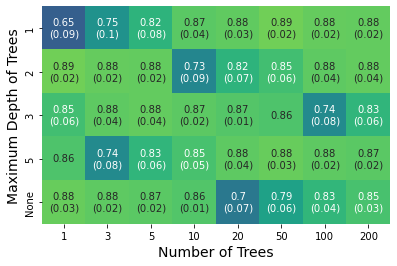

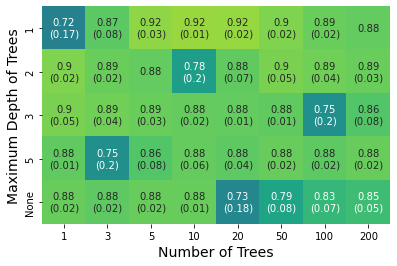

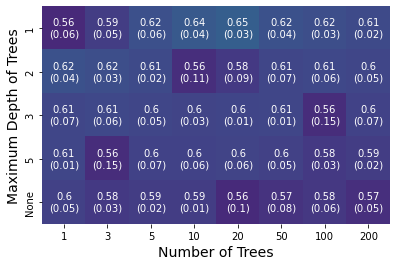

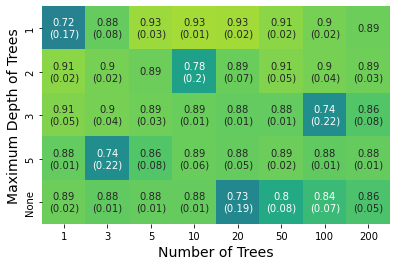

In [36]:
_, ROH_CV_score_array,\
ROH_het_score_array, ROH_alkyl_score_array, ROH_anil_score_array = prep_heatmap_friendly_arrays(
                                ROH_CV_dict_list, depth_list, num_tree_list, 25
                        )
prep_heatmap(ROH_CV_score_array, depth_list, num_tree_list,
             "FigS6", "ROH", "CV", True) # Figure S6
prep_heatmap(ROH_anil_score_array, depth_list, num_tree_list,
             "FigS9", "ROH", "aniline", True) #Figure S9
prep_heatmap(ROH_het_score_array, depth_list, num_tree_list,
             "FigS9", "ROH", "heterocycle", True) #Figure S9
prep_heatmap(ROH_alkyl_score_array, depth_list, num_tree_list,
             "FigS9", "ROH", "alkyl", True) #Figure S9

## Target : Bpin - Figure S10

In [39]:
Bpin_list = joblib.load("./array_joblibs/common_Bpin_arrays.joblib")

In [42]:
depth_list = [1,2,3,5,None]
num_tree_list = [1,3,5,10,20,50,100]
Bpin_CV_dict_list = []

for j,source in enumerate(["amides", "sulfonamides", "ROH"]):
    for i in range(25):
        if i==0 : cv_result_dict=None
        else : cv_result_dict = full_CV_dict
        full_CV_dict = screen_depth_and_num_trees(
                        source_desc_dict[source], 
                        source_y_dict[source],
                        [Bpin_list[j][0]],
                        [Bpin_list[j][1]],
                        depth_list, num_tree_list, random_state=42+i,
                        cv_result_dict=cv_result_dict
                    )
    Bpin_CV_dict_list.append(full_CV_dict)

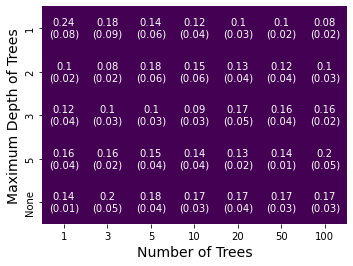

In [27]:
### Source: Amide
_, _,\
amide_Bpin_score_array, _, _ = prep_heatmap_friendly_arrays(
                                Bpin_CV_dict_list[0], depth_list, num_tree_list, 25
                        )
prep_heatmap(amide_Bpin_score_array, depth_list, num_tree_list,
             "FigS10", "amides", "Bpin", True)

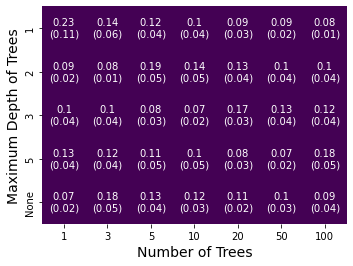

In [13]:
### Source: Sulfonamide
_, _,\
sulfon_Bpin_score_array, _, _ = prep_heatmap_friendly_arrays(
                                Bpin_CV_dict_list[1], depth_list, num_tree_list, 25
                        )
prep_heatmap(sulfon_Bpin_score_array, depth_list, num_tree_list,
             "FigS10", "sulfonamides", "Bpin", True)

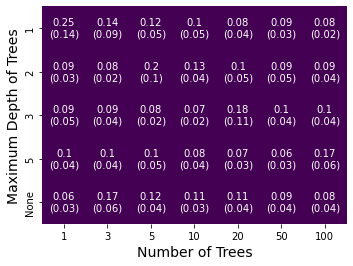

In [26]:
### Source: ROH
_, _,\
ROH_Bpin_score_array, _, _ = prep_heatmap_friendly_arrays(
                                Bpin_CV_dict_list[2], depth_list, num_tree_list, 25
                        )
prep_heatmap(ROH_Bpin_score_array, depth_list, num_tree_list,
             "FigS10", "ROH", "Bpin", True)

# N-nucs --> piperidyl-amide - Supports Figure S20

In [19]:
pip_id = joblib.load("./array_joblibs/arrays_for_additional_ATL/pip_id.joblib")
pip_desc = joblib.load("./array_joblibs/arrays_for_additional_ATL/pip_desc.joblib")
pip_y = joblib.load("./array_joblibs/arrays_for_additional_ATL/pip_y.joblib")

In [20]:
depth_list = [1,2,3,5,None]
num_tree_list = [1,3,5,10,20,50,100]
pip_y[pip_y>0] = 1
pip_CV_dict_list = []
for j,source in enumerate(["amides", "sulfonamides", "ROH"]):
    for i in range(25):
        if i==0 : cv_result_dict=None
        else : cv_result_dict = full_CV_dict
        full_CV_dict = screen_depth_and_num_trees(
                        source_desc_dict[source], 
                        source_y_dict[source],
                        [pip_desc],
                        [pip_y],
                        depth_list, num_tree_list, random_state=42+i,
                        cv_result_dict=cv_result_dict
                    )
    pip_CV_dict_list.append(full_CV_dict)

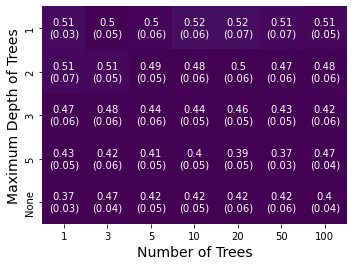

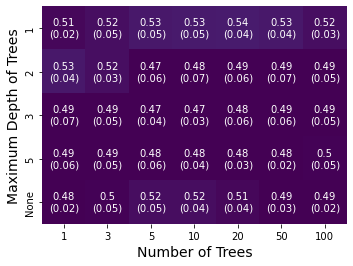

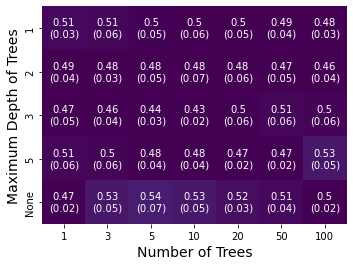

In [21]:
### Source: Amide
for i in range(3):
    _, _,\
    amide_pip_score_array = prep_heatmap_friendly_arrays(
                                pip_CV_dict_list[i], depth_list, [1,3,5,10,20,50,100], 25, 1
                        )
    prep_heatmap(amide_pip_score_array, depth_list, num_tree_list,
             False, domains[i], "piperidyl amide")

In [32]:
### Below is to see how hard it is to model
### reactions of piperidyl-amide on its own.

depth_list = [1,2,3,5,None]
num_tree_list = [1,3,5,10,20,50,100]
pip_y[pip_y>0] = 1

for i in range(25):
    if i==0 : cv_result_dict=None
    else : cv_result_dict = pip_CV_dict
    pip_CV_dict = screen_depth_and_num_trees(
                        pyBOH2_desc, 
                        pyBOH2_y,
                        [Bpin_desc],
                        [Bpin_y],
                        depth_list, num_tree_list, random_state=42+i,
                        cv_result_dict=cv_result_dict
                    )

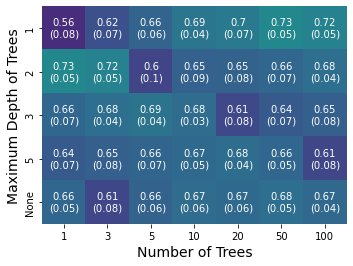

In [33]:
_, pip_CV_score_array,\
_ = prep_heatmap_friendly_arrays(
                                pip_CV_dict, depth_list, [1,3,5,10,20,50,100], 25, 1
                        )

prep_heatmap(pip_CV_score_array, depth_list, num_tree_list,
             False, "pip", "CV")

# Malonate --> 2-indanone - Figure S21

In [21]:
malon_source_arrays = joblib.load("./array_joblibs/malon_source_arrays.joblib")
indanone_arrays = joblib.load("./array_joblibs/indanone_arrays_for_ATL.joblib")

In [22]:
depth_list = [1,2,3,5,None]
num_tree_list = [1,3,5,10,20,50,100]

for i in range(25):
    if i==0 : cv_result_dict=None
    else : cv_result_dict = full_CV_dict
    full_CV_dict = screen_depth_and_num_trees(
                        malon_source_arrays[1], 
                        malon_source_arrays[2],
                        [indanone_arrays[1]],
                        [indanone_arrays[2]],
                        depth_list, num_tree_list, random_state=42+i,
                        cv_result_dict=cv_result_dict
                    )

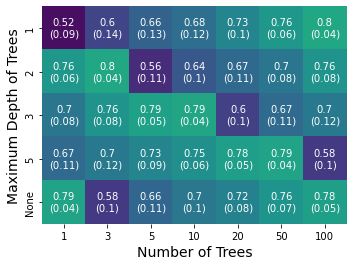

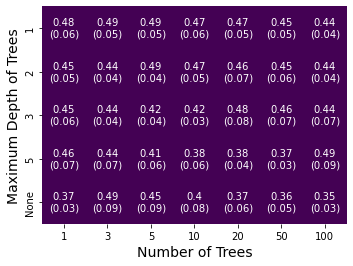

In [23]:
_, malon_CV_score_array,\
malon_indan_score_array = prep_heatmap_friendly_arrays(
                                full_CV_dict, depth_list, num_tree_list, 25, 1
                        )
prep_heatmap(malon_CV_score_array, depth_list, num_tree_list,
             False, "Malonate", "CV")
prep_heatmap(malon_indan_score_array, depth_list, num_tree_list,
             False, "Malonate", "indanone")

# Between Suzuki - Figure S22

In [12]:
pyBOH2_id = joblib.load("./array_joblibs/arrays_for_additional_ATL/pyBOH2_id.joblib")
pyBOH2_y = joblib.load("./array_joblibs/arrays_for_additional_ATL/pyBOH2_y.joblib")
pyBOH2_desc = joblib.load("./array_joblibs/arrays_for_additional_ATL/pyBOH2_desc.joblib")

In [13]:
full_id_arrays_by_nuc = joblib.load("./array_joblibs/full_id_arrays_by_nuc.joblib")
full_desc_arrays_by_nuc = joblib.load("./array_joblibs/full_desc_arrays_by_nuc.joblib")
full_y_arrays_by_nuc = joblib.load("./array_joblibs/full_y_arrays_by_nuc.joblib")

Bpin_id = full_id_arrays_by_nuc["Bpin"]
Bpin_desc = full_desc_arrays_by_nuc["Bpin"]
Bpin_y = full_y_arrays_by_nuc["Bpin"]

# Remove catalysts 4, 7 and 11 reactions for electrophile 2
# to secure some number of 'new reagent combination' in target
# 4, 7 and 11 were chosen to make the problem as hard as possible
# (they give the most number of positive yields with elec 2)
overlap_cat_inds = list(np.where(np.all(Bpin_id[:,1:3]==[2,4], axis=1))[0]) +\
    list(np.where(np.all(Bpin_id[:,1:3]==[2,7], axis=1))[0]) +\
    list(np.where(np.all(Bpin_id[:,1:3]==[2,11], axis=1))[0])
inds = [x for x in range(Bpin_id.shape[0]) if x not in overlap_cat_inds]
Bpin_id = Bpin_id[inds]
Bpin_desc = Bpin_desc[inds]
Bpin_y = Bpin_y[inds]

In [14]:
depth_list = [1,2,3,5,None]
num_tree_list = [1,3,5,10,20,50,100]

for i in range(25):
    if i==0 : cv_result_dict=None
    else : cv_result_dict = full_CV_dict
    full_CV_dict = screen_depth_and_num_trees(
                        Bpin_desc, 
                        Bpin_y,
                        [pyBOH2_desc],
                        [pyBOH2_y],
                        depth_list, num_tree_list, random_state=42+i,
                        cv_result_dict=cv_result_dict
                    )

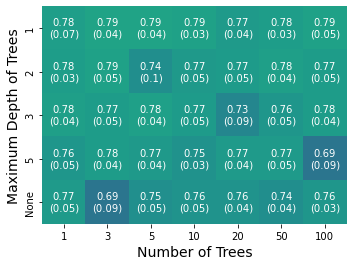

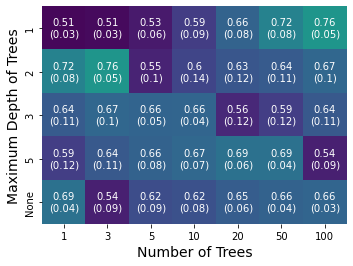

In [19]:
_, Bpin_CV_score_array,\
Bpin_pyBOH2_score_array = prep_heatmap_friendly_arrays(
                                full_CV_dict, depth_list, [1,3,5,10,20,50,100], 25, 1
                        )

prep_heatmap(Bpin_CV_score_array, depth_list, num_tree_list,
             False, "Bpin", "CV")
prep_heatmap(Bpin_pyBOH2_score_array, depth_list, num_tree_list,
             False, "Bpin", "PyrBOH2")

In [29]:
### Below is to see how hard it is to model
### reactions of pyridin-3-boronic acid on its own.

depth_list = [1,2,3,5,None]
num_tree_list = [1,3,5,10,20,50,100]
pyBOH2_y[pyBOH2_y>0] = 1

for i in range(25):
    if i==0 : cv_result_dict=None
    else : cv_result_dict = full_CV_dict
    full_CV_dict = screen_depth_and_num_trees(
                        pyBOH2_desc, 
                        pyBOH2_y,
                        [Bpin_desc],
                        [Bpin_y],
                        depth_list, num_tree_list, random_state=42+i,
                        cv_result_dict=cv_result_dict
                    )

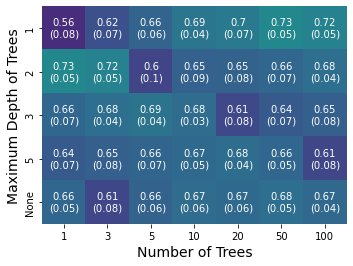

In [30]:
_, BOH2_CV_score_array,\
_ = prep_heatmap_friendly_arrays(
                                full_CV_dict, depth_list, [1,3,5,10,20,50,100], 25, 1
                        )

prep_heatmap(BOH2_CV_score_array, depth_list, num_tree_list,
             False, "BOH2", "CV")